In [5]:
import sys
sys.path.append('../')
from Utils import *
from einops import rearrange
import matplotlib.pyplot as plt

In [6]:
# Read one subject/case from a directory containing the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/DemoData'

# `load_mat` takes the .mat file path and variable name (`key`) as input.
# It returns a lazy HDF5-like handle (h5py-style): data is not loaded into memory
# until you index it.
# load a pre-reconstructed image (assumed to be already reconstructed)
kdata_full = load_mat(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap    = load_mat(data_dir + '/coilmap.mat',    key='coilmap')
segmask    = load_mat(data_dir + '/segmask.mat',    key='segmask')
params     = read_params_csv(data_dir + '/params.csv')
img_csllr = load_mat(data_dir + '/img_csllr.mat', key='img_csllr')
# Use [()] to materialize the entire dataset into RAM as a NumPy array.
kdata_full = kdata_full[()]
coilmap    = coilmap[()]
segmask    = segmask[()]
img_csllr = img_csllr[()]

img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)
Nv, Nt, SPE, PE, FE = img.shape

VENC = params['VENC']
VOrder = params['venc_order']

Due to system imperfections (notably gradient field nonlinearity), voxels farther from the FOV center can exhibit a spatially dependent, often time-stable background phase offset. A compact model is:

$$
img_v(\mathbf{r}) = M_v(\mathbf{r}) \exp\left(i\left[\theta_0(\mathbf{r}) + \theta_v(\mathbf{r}) + \Delta\theta^{bg}(\mathbf{r})\right]\right)
$$

where $\Delta\theta^{bg}(\mathbf{r})$ is the position-dependent phase offset; in post-processing it is commonly removed by fitting a smooth model and canceling it in the complex domain.

In [7]:
# Estimate the background-phase correction maps from the ground-truth image `img`.
corr_maps = execute_MSAC(img, corr_fit_order=3, th=0.1)

# Apply the estimated correction to the reconstructed complex image `img_csllr`
# by canceling the background phase in the complex domain.
img_corr = img_csllr.copy()
img_corr[1:] *= np.exp(1j * (-corr_maps))

mag, flow = complex2magflow(img_csllr)
mag_corr, flow_corr = complex2magflow(img_corr)

showing v=1, t=1, s=14


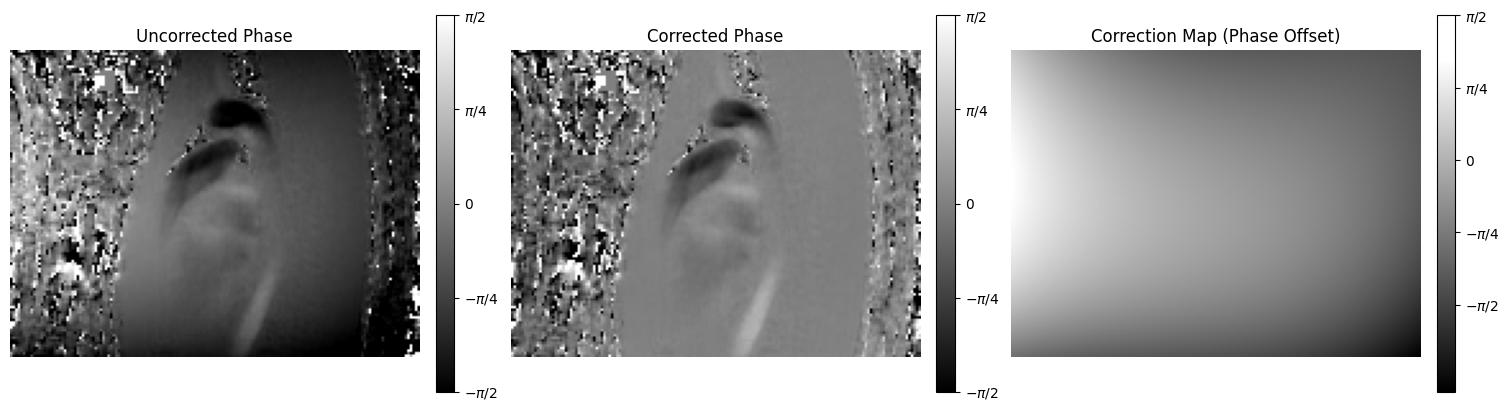

In [8]:
v = 1
t = 1
s = 14

print(f"showing v={v}, t={t}, s={s}")

# Extract one slice and transpose for display
sl_phase      = flow[v, t, s, :, :].T
sl_phase_corr = flow_corr[v, t, s, :, :].T
sl_corrmap    = corr_maps[v, 0, s, :, :].T

sl_diff = sl_phase_corr - sl_phase  # not shown here, kept for later use

# Display range for phase images
phase_vmin, phase_vmax = -np.pi / 2, np.pi / 2

fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Common pi-formatted ticks/labels for colorbars
ticks  = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]
labels = [r"$-\pi/2$", r"$-\pi/4$", r"$0$", r"$\pi/4$", r"$\pi/2$"]

im00 = ax[0].imshow(sl_phase, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[0].set_title("Uncorrected Phase")
ax[0].axis("off")
cb0 = fig.colorbar(im00, ax=ax[0], fraction=0.046, pad=0.04)  # add colorbar
cb0.set_ticks(ticks)                                          # set tick locations (in radians)
cb0.set_ticklabels(labels)                                    # show ticks as multiples of pi

im01 = ax[1].imshow(sl_phase_corr, cmap="gray", origin="lower", vmin=phase_vmin, vmax=phase_vmax)
ax[1].set_title("Corrected Phase")
ax[1].axis("off")
cb1 = fig.colorbar(im01, ax=ax[1], fraction=0.046, pad=0.04)
cb1.set_ticks(ticks)
cb1.set_ticklabels(labels)

im10 = ax[2].imshow(sl_corrmap, cmap="gray", origin="lower")
ax[2].set_title("Correction Map (Phase Offset)")
ax[2].axis("off")
cb2 = fig.colorbar(im10, ax=ax[2], fraction=0.046, pad=0.04)
cb2.set_ticks(ticks)
cb2.set_ticklabels(labels)

plt.show()